<style>
@font-face {
  font-family: CharisSILW;
  src: url(files/CharisSIL-R.woff);
}
@font-face {
  font-family: CharisSILW;
  font-style: italic;
  src: url(files/CharisSIL-I.woff);
}
@font-face {
	font-family: CharisSILW;
	font-weight: bold;
	src: url(files/CharisSIL-B.woff);
}
@font-face {
	font-family: CharisSILW;
	font-weight: bold;
	font-style: italic;
	src: url(files/CharisSIL-BI.woff);
}

div.cell, div.text_cell_render{
    max-width:1000px;
}

h1 {
    text-align:center;
    font-family: Charis SIL, CharisSILW, serif;
}

.rendered_html {
    font-size: 130%;
    line-height: 1.3;
}

.rendered_html li {
    line-height: 2;
}

.rendered_html h1{
    line-height: 1.3;
}

.rendered_html h2{
    line-height: 1.2;
}

.rendered_html h3{
    line-height: 1.0;
}

.text_cell_render {
    font-family: Charis SIL, CharisSILW, serif;
    line-height: 145%;
}

li li {
    font-size: 85%;
}
</style>

Lab
==========================================
Gradient Boosted Regression Trees
------------------------------------------
Alessandro D. Gagliardi  
*(adapted from Peter Prettenhofer's tutorial)*

In [16]:
import pandas as pd
import numpy as np

Scikit-learn provides two estimators for gradient boosting: ``GradientBoostingClassifier`` and ``GradientBoostingRegressor``, both are located in the ``sklearn.ensemble`` package:

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

Estimators support arguments to control the fitting behaviour -- these arguments are often called _hyperparameters_. Among the most important ones for GBRT are:

  * number of regression trees (``n_estimators``)
  * depth of each individual tree (``max_depth``)
  * loss function (``loss``)

For example if you want to fit a regression model with 100 trees of depth 3 using least-squares:

In [18]:
est = GradientBoostingRegressor(n_estimators=100, max_depth=3, loss='ls')

In [5]:
est?

Here is an self-contained example that shows how to fit a ``GradientBoostingClassifier`` to a synthetic dataset:

In [6]:
from sklearn.datasets import make_hastie_10_2
from sklearn.cross_validation import train_test_split

# generate synthetic data from ESLII - Example 10.2
X, y = make_hastie_10_2(n_samples=5000)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# fit estimator
est = GradientBoostingClassifier(n_estimators=200, max_depth=3)
est.fit(X_train, y_train)

# predict class labels
pred = est.predict(X_test)

# score on test data (accuracy)
acc = est.score(X_test, y_test)
print('ACC: %.4f' % acc)

# predict class probabilities
est.predict_proba(X_test)[0]

ACC: 0.9064


array([ 0.1395258,  0.8604742])

The state of the estimator is stored in instance attributes that have a trailing underscore ('\_'). For example, the sequence of regression trees (``DecisionTreeRegressor`` objects) is stored in ``est.estimators_``:

In [ ]:
est.estimators_[0, 0]

## Gradient Boosted Regression Trees in Practise

### Function approximation

  * Sinoide function + random gaussian noise 
  * 80 training (blue), 20 test (red) points

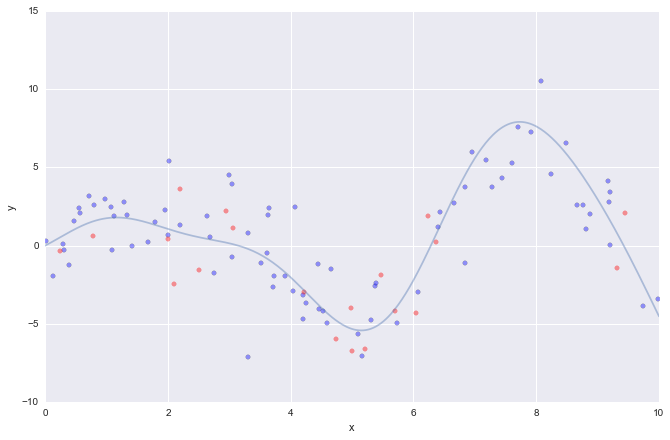

In [19]:
%matplotlib inline
import numpy as np
from seaborn import plt
from sklearn.cross_validation import train_test_split

FIGSIZE = (11, 7)

def ground_truth(x):
    """Ground truth -- function to approximate"""
    return x * np.sin(x) + np.sin(2 * x)

def gen_data(n_samples=200):
    """generate training and testing data"""
    np.random.seed(15)
    X = np.random.uniform(0, 10, size=n_samples)[:, np.newaxis]
    y = ground_truth(X.ravel()) + np.random.normal(scale=2, size=n_samples)
    train_mask = np.random.randint(0, 2, size=n_samples).astype(np.bool)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = gen_data(100)

# plot ground truth
x_plot = np.linspace(0, 10, 500)

def plot_data(alpha=0.4, s=20):
    fig = plt.figure(figsize=FIGSIZE)
    gt = plt.plot(x_plot, ground_truth(x_plot), alpha=alpha, label='ground truth')

    # plot training and testing data
    plt.scatter(X_train, y_train, s=s, alpha=alpha)
    plt.scatter(X_test, y_test, s=s, alpha=alpha, color='red')
    plt.xlim((0, 10))
    plt.ylabel('y')
    plt.xlabel('x')
    
annotation_kw = {'xycoords': 'data', 'textcoords': 'data',
                 'arrowprops': {'arrowstyle': '->', 'connectionstyle': 'arc'}}
    
plot_data()

### Regression Trees

  * ``max_depth`` argument controlls the depth of the tree
  * The deeper the tree the more variance can be explained

In [ ]:
from sklearn.tree import DecisionTreeRegressor
plot_data()
est = DecisionTreeRegressor(max_depth=1).fit(X_train, y_train)
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]),
         label='RT max_depth=1', color='g', alpha=0.9, linewidth=2)

est = DecisionTreeRegressor(max_depth=3).fit(X_train, y_train)
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]),
         label='RT max_depth=3', color='g', alpha=0.7, linewidth=1)

plt.legend(loc='upper left')

### Function approximation with Gradient Boosting

  * ``n_estimators`` argument controls the number of trees
  * ``staged_predict`` method allows us to step through predictions as we add more trees

In [ ]:
from itertools import islice

plot_data()
est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0)
est.fit(X_train, y_train)

ax = plt.gca()
first = True

# step through prediction as we add 10 more trees.
for pred in islice(est.staged_predict(x_plot[:, np.newaxis]), 0, est.n_estimators, 10):
    plt.plot(x_plot, pred, color='r', alpha=0.2)
    if first:
        ax.annotate('High bias - low variance', xy=(x_plot[x_plot.shape[0] // 2],
                                                    pred[x_plot.shape[0] // 2]),
                                                    xytext=(4, 4), **annotation_kw)
        first = False

pred = est.predict(x_plot[:, np.newaxis])
plt.plot(x_plot, pred, color='r', label='GBRT max_depth=1')
ax.annotate('Low bias - high variance', xy=(x_plot[x_plot.shape[0] // 2],
                                            pred[x_plot.shape[0] // 2]),
                                            xytext=(6.25, -6), **annotation_kw)
plt.legend(loc='upper left')

### Model complexity

  * The number of trees and the depth of the individual trees control model complexity
  * Model complexity comes at a price: **overfitting**
  
  
### Deviance plot

  * Diagnostic to determine if model is overfitting
  * Plots the training/testing error (deviance) as a function of the number of trees (=model complexity)
  * Training error (deviance) is stored in ``est.train_score_``
  * Test error is computed using ``est.staged_predict``

In [ ]:
def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6', 
                  test_color='#d7191c', alpha=1.0, ylim=(0, 10)):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    n_estimators = len(est.estimators_)
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
       test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure(figsize=FIGSIZE)
        ax = plt.gca()
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, 
             linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color, 
             label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim(ylim)
    return test_dev, ax

test_dev, ax = deviance_plot(est, X_test, y_test)
ax.legend(loc='upper right')

# add some annotations
ax.annotate('Lowest test error', xy=(test_dev.argmin() + 1, test_dev.min() + 0.02),
            xytext=(150, 3.5), **annotation_kw)

ann = ax.annotate('', xy=(800, test_dev[799]),  xycoords='data',
                  xytext=(800, est.train_score_[799]), textcoords='data',
                  arrowprops={'arrowstyle': '<->'})
ax.text(810, 3.5, 'train-test gap')

### Overfitting

  * Model has too much capacity and starts fitting the idiosyncracies of the training data
  * Indicated by a large gap between train and test error
  * GBRT provides a number of knobs to control overfitting

## Regularization

  * Tree structure
  * Shrinkage
  * Stochastic Gradient Boosting

## Tree Structure

  * The ``max_depth`` of the trees controls the degree of features interactions (variance++)
  * Use ``min_samples_leaf`` to have a sufficient number of samples per leaf (bias++)

In [ ]:
def fmt_params(params):
    return ", ".join("{0}={1}".format(key, val) for key, val in params.iteritems())

fig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'min_samples_leaf': 3}, ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, 
                                    learning_rate=1.0)
    est.set_params(**params)
    est.fit(X_train, y_train)
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Higher bias', xy=(900, est.train_score_[899]), xytext=(600, 3), **annotation_kw)
ax.annotate('Lower variance', xy=(900, test_dev[899]), xytext=(600, 3.5), **annotation_kw)
plt.legend(loc='upper right')

## Shrinkage

 * Slow learning by shrinking the predictions of each tree by some small scalar (``learning_rate``)
 * A lower ``learning_rate`` requires a higher number of ``n_estimators``
 * Its a trade-off between runtime against accuracy.

In [ ]:
fig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'learning_rate': 0.1},
                                           ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0)
    est.set_params(**params)
    est.fit(X_train, y_train)
    
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Requires more trees', xy=(200, est.train_score_[199]), 
            xytext=(300, 1.75), **annotation_kw)
ax.annotate('Lower test error', xy=(900, test_dev[899]),
            xytext=(600, 1.75), **annotation_kw)
plt.legend(loc='upper right')

## Stochastic Gradient Boosting

 * Subsampling the training set before growing each tree (``subsample``)
 * Subsampling the features before finding the best split node (``max_features``)
 * Latter usually works better if there is a sufficient large number of features

In [ ]:
fig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'learning_rate': 0.1, 'subsample': 0.5},
                                           ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0,
                                    random_state=1)
    est.set_params(**params)
    est.fit(X_train, y_train)
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Even lower test error', xy=(400, test_dev[399]),
            xytext=(500, 3.0), **annotation_kw)

est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0,
                                subsample=0.5)
est.fit(X_train, y_train)
test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params({'subsample': 0.5}),
                             train_color='#abd9e9', test_color='#fdae61', alpha=0.5)
ax.annotate('Subsample alone does poorly', xy=(300, test_dev[299]), 
            xytext=(500, 5.5), **annotation_kw)
plt.legend(loc='upper right', fontsize='small')

## Hyperparameter tuning

I usually follow this recipe to tune the hyperparameters:

  1. Pick ``n_estimators`` as large as (computationally) possible (e.g. 3000)
  2. Tune ``max_depth``, ``learning_rate``, ``min_samples_leaf``, and ``max_features`` via grid search
  3. Increase ``n_estimators`` even more and tune ``learning_rate`` again holding the other parameters fixed

In [ ]:
from sklearn.grid_search import GridSearchCV

param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5]  ## depends on the nr of training examples
              # 'max_features': [1.0, 0.3, 0.1] ## not possible in our example (only 1 fx)
              }

est = GradientBoostingRegressor(n_estimators=3000)
# this may take some minutes
gs_cv = GridSearchCV(est, param_grid, scoring='mean_squared_error', n_jobs=4).fit(X_train, y_train)

# best hyperparameter setting
print('Best hyperparameters: %r' % gs_cv.best_params_)

In [ ]:
# refit model on best parameters
est.set_params(**gs_cv.best_params_)
est.fit(X_train, y_train)

# plot the approximation
plot_data()
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='r', linewidth=2)

Caution: Hyperparameters interact with each other (``learning_rate`` and ``n_estimators``, ``learning_rate`` and ``subsample``, ``max_depth`` and ``max_features``).

See [G. Ridgeway, "Generalized boosted models: A guide to the gbm package", 2005](http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=540A0A638283F64E251B1342248CDBCF?doi=10.1.1.151.4024&rep=rep1&type=pdf)

In Pairs
==========================================
California Housing
------------------------------------------
<img src="assets/cal-housing.png" />  

 * Predict the median house value for census block groups in California
 * 20.000 groups, 8 features: *median income*, *average house age*, *latitude*, *longitude*, ...
 * Mean Absolute Error on 80-20 train-test split

In [42]:
from sklearn.datasets.california_housing import fetch_california_housing

cal_housing = fetch_california_housing()

# split 80/20 train-test
X_train, X_test, y_train, y_test = train_test_split(cal_housing.data,
                                                    cal_housing.target,
                                                    test_size=0.2,
                                                    random_state=1)
names = cal_housing.feature_names

## Challenges

  * heterogenous features (different scales and distributions, see plot below)
  * non-linear feature interactions (interaction: latitude and longitude)
  * extreme responses (robust regression techniques)


In [43]:
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence

Task
----
1. Plot histograms of the `Latitude`, `Longitude`, Median Income (`MedInc`), and Median House Value (`y_train`)
2. Evaluate and compare the `mean_absolute_error` of 
    - `GradientBoostingRegressor` 
    - `RandomForestRegressor`
    - `DecisionTreeRegressor`
    - `DummyRegressor`
3. Tune the models (except `DummyRegressor`) as shown above  
    (this time include `max_features` as a hyperparameter):
    - Use the `deviance_plot` function defined above to check whether you are in the high-bias or high-variance regime.
    - Hint: for `DecisionTreeRegressor` and `RandomForestRegressor`, 
        look at the docs to see which hyperparameters need tuning.  
4. Plot feature importance (using the `.feature_importances_` property)
    - Hint: load `feature_importances_` into a `pandas.Series` and use `.plot(kind='barh')` 
5. `plot_partial_dependence` on `MedInc`, `AveOccup`, `HouseAge`, and `('AveOccup', 'HouseAge')`.
    - `('AveOccup', 'HouseAge')` will show you the interaction between these two features.

In [67]:
cal_housing.data.shape

(20640, 8)

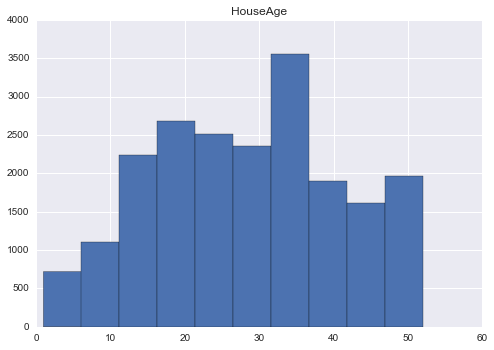

In [45]:
plt.hist(cal_housing.data[:,1])
plt.title(cal_housing.feature_names[1])

(array([ 1796.,  8987.,   747.,   474.,  1292.,  4712.,  1740.,   490.,
          324.,    78.]),
 array([ 32.54 ,  33.481,  34.422,  35.363,  36.304,  37.245,  38.186,
         39.127,  40.068,  41.009,  41.95 ]),
 <a list of 10 Patch objects>)

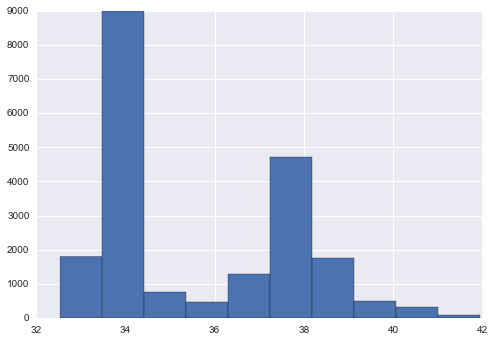

In [47]:
plt.hist(cal_housing.data[:,-2])

In [95]:
est = GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=1.0)
est.fit(X_train, y_train)
y_pred = est.predict(X_test)
est.loss_(y_test,y_pred)

0.37779000121238759

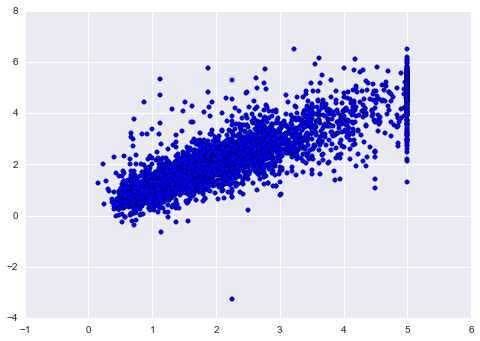

In [96]:
plt.scatter(y_test,y_pred)

In [98]:
from sklearn.grid_search import GridSearchCV

param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5]  ## depends on the nr of training examples
              # 'max_features': [1.0, 0.3, 0.1] ## not possible in our example (only 1 fx)
              }

est = GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=1.0)
# this may take some minutes
gs_cv = GridSearchCV(est, param_grid, scoring='mean_squared_error', n_jobs=4).fit(X_train, y_train)

# best hyperparameter setting
print('Best hyperparameters: %r' % gs_cv.best_params_)

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 5}


In [99]:
est = GradientBoostingRegressor(n_estimators=200, max_depth=6, learning_rate=0.1)
est.fit(X_train, y_train)
y_pred = est.predict(X_test)
est.loss_(y_test,y_pred)

0.21150253049967305

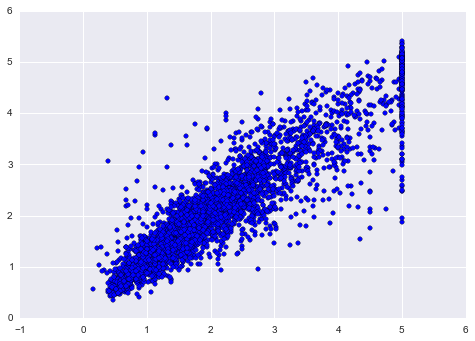

In [101]:
plt.scatter(y_test,y_pred)

On Your Own
========
Go through the following tutorials on your own:

1. Decision Trees: http://scikit-learn.org/stable/modules/tree.html
2. Random Forests: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html

Then:

- Finish the California Housing assignment if you were not able to finish it in class.